In [27]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


def minkowski_distance(point_a: np.ndarray, point_b: np.ndarray, p: float) -> np.ndarray:
    absolute_difference = np.abs(point_a - point_b)
    power_in_sum = np.power(absolute_difference, p)
    summa = np.sum(power_in_sum)
    return np.power(summa, 1/p)


def minkowski_loss(cluster: np.ndarray, centroid: np.ndarray, p: float) -> np.ndarray:
    '''
    SGD Minkowski Loss function.
    Return the coordinate sum of the Minkowski differences
    Formula: [∑_j (xji - ci)^p]
    '''
    loss = []
    for point in cluster:
        absolute_difference = np.abs(point - centroid)
        power_in_sum = np.power(absolute_difference, p)
        loss.append(power_in_sum)
    loss = np.array(loss)
    dim_loss = np.sum(loss, axis=0)
    return dim_loss


class KMeans:
    def __init__(self, n_clusters, max_iter=100, p=2):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.p = p
        self.centroids = []
        self.labels = []

    def fit(self, X):
        # initialize centroids randomly
        self.centroids = [X[i] for i in np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            clusters = [[] for _ in range(self.n_clusters)]
            self.labels = []

            # assign each data point to the closest centroid
            for x in X:
                distances_to_each_cebtroid = [minkowski_distance(x, centroid, self.p) for centroid in self.centroids]
                closest_centroid = np.argmin(distances_to_each_cebtroid)
                clusters[closest_centroid].append(x)
                self.labels.append(closest_centroid)

            # update centroids using the specified optimizer
            for j, cluster in enumerate(clusters):
                cluster = np.array(cluster)
                if len(cluster) == 0:
                    continue
                if self.p == 2:
                    self.centroids[j] = np.mean(cluster, axis=0)
                elif self.p == 1:
                    self.centroids[j] = np.median(cluster, axis=0)
                elif self.p > 1:
                    '''
                    SGD optimizer
                    Amorim, Renato. (2012). Feature Weighting for Clustering: Using K-Means and the Minkowski Metric. 
                    '''
                    learning_rate = 0.01
                    grad_descent = 0.1
                    n_iters = 50
                    centroid = np.mean(cluster, axis=0)

                    for sgd_iteration in range(n_iters):
                        if sgd_iteration == n_iters / 2:
                            learning_rate *= grad_descent
                        loss = minkowski_loss(cluster, centroid, self.p)
                        grad = np.gradient(loss, axis=0)
                        centroid -= learning_rate * grad
                    self.centroids[j] = centroid
                elif 0 < self.p < 1:
                    '''
                    WIP
                    '''
                    raise ValueError(f'Unsupported value of p: {self.p}')
                    # points_in_cluster = len(cluster)
                    # dimentionality = len(cluster[0])
                    # data = [[] for _ in range(points_in_cluster)]

                    # for point_id, point in enumerate(cluster):
                    #     for coordinate_id in range(dimentionality):
                    #         data[point_id].append(point[coordinate_id])
                    # self.centroids[j] = np.median(cluster, axis=1)

                # elif self.optimizer == 'SLSQP':
                #     bounds = [(None, None)] * self.centroids[j].shape[0]
                #     self.centroids[j] = minimize(
                #         lambda x: minkowski_distance(x, cluster, self.p),
                #         self.centroids[j].flatten(),
                #         method=self.optimizer,
                #         bounds=bounds
                #     ).x.copy()
                # elif self.optimizer in ('Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'trust-constr'):
                #     self.centroids[j] = minimize(lambda x: minkowski_distance(x, cluster, self.p), self.centroids[j],
                # method=self.optimizer).x.copy()
                else:
                    raise ValueError(f'Unsupported value of p: {self.p}')

        return self.centroids, self.labels

In [36]:
from typing import List, Tuple, Optional
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
import matplotlib.pyplot as plt
import pandas as pd


def generate_gaussian_clusters(
    centroid_locations: List[List],
    sigma: float,
    dimension: int,
    n_points_per_cluster: int = 100
    ) -> Tuple[np.ndarray, np.ndarray]:

    clusters = []
    labels = []
    randomizer = np.random.default_rng()

    for cluster_id, centroid_location in enumerate(centroid_locations):
        cluster_size = (n_points_per_cluster, dimension)
        labels_size = (n_points_per_cluster, )

        cluster_points = randomizer.normal(
            loc=centroid_location,
            scale=sigma,
            size=cluster_size
        )

        cluster_labels = np.full(shape=labels_size, fill_value=cluster_id)

        clusters.append(cluster_points)
        labels.append(cluster_labels)

    return np.concatenate(clusters), np.concatenate(labels)


def generate_cluster_centroids(
    dimension: int,
    n_clusters: int,
    distance_factor: float
    ) -> np.ndarray:

    centroid_locations = np.stack([np.random.random(dimension) * distance_factor for _ in range(n_clusters)])
    return centroid_locations


def get_one_experiment_metrics(
    true_labels: List,
    pred_labels: List,
    p: Optional[float] = None,
    time: Optional[float] = None) -> pd.DataFrame:

    ari = adjusted_rand_score(true_labels, pred_labels)
    ami = adjusted_mutual_info_score(true_labels, pred_labels)

    data = {'Adjusted Rand Index': ari, 'Mutual Information Score': ami}
    if time:
        data['Time'] = time
    index = [f'Experiment with p: {p}'] if p else [f'Experiment'] 
    frame = pd.DataFrame(data, index)
    return frame


class MetricTable:

    def __init__(self) -> None:
        self.frames = []

    def add_frame(self, frame: pd.DataFrame) -> None:
        self.frames.append(frame)

    def print(self) -> None:
        print(pd.concat(self.frames, join="inner"))


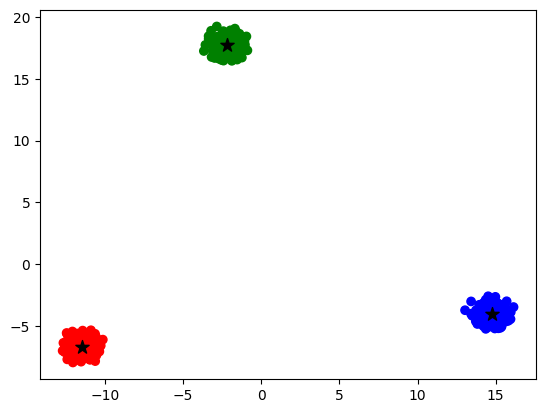

In [40]:
from sklearn.manifold import TSNE


dimension = 512 # dimensionality
n_clusters = 3 # Number of clusters
distance_factor = 0.2 # allows to increase distances between cluster centroids
sigma = 0.1 # STD distribution
n_points_per_cluster = 100

centroid_locations = generate_cluster_centroids(
    dimension=dimension,
    n_clusters=n_clusters,
    distance_factor=distance_factor
)

clusters, labels = generate_gaussian_clusters(
    dimension=dimension,
    sigma=sigma,
    centroid_locations=centroid_locations,
    n_points_per_cluster=n_points_per_cluster
)


def print_clusters(clusters: np.ndarray,
                   labels: np.ndarray,
                   centroids: Optional[np.ndarray] = None) -> None:
    color_map = {
        0: 'blue',
        1: 'red',
        2: 'green'
    }
    colors = [color_map[label] for label in labels]
    tsne = TSNE(n_components=2, random_state=42)

    if not isinstance(centroids, type(None)):
        concuted = np.concatenate((clusters, np.array(centroids)), axis=0)
        clusters_tsne = tsne.fit_transform(concuted)

        plt.scatter(clusters_tsne[:-len(centroids),0], clusters_tsne[:-len(centroids),1], c=colors)
        plt.scatter(clusters_tsne[-len(centroids):,0], clusters_tsne[-len(centroids):,1], marker='*', s = 100, c='black')
    else:
        clusters_tsne = tsne.fit_transform(clusters)
        plt.scatter(clusters_tsne[:,0], clusters_tsne[:,1], c=colors)
    plt.show()

print_clusters(clusters, labels, centroid_locations)

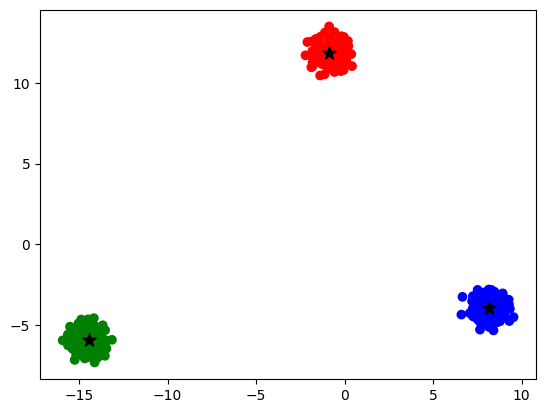

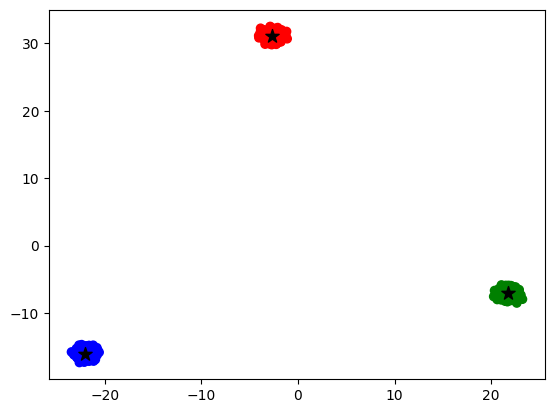

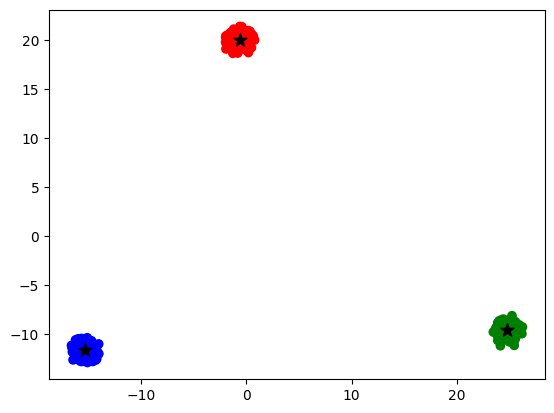

                      Adjusted Rand Index  Mutual Information Score       Time
Experiment with p: 2                  1.0                       1.0   1.329650
Experiment with p: 1                  1.0                       1.0   1.781305
Experiment with p: 3                  1.0                       1.0  16.559746


In [41]:
import time

frames = []

metrics = MetricTable()

for p in [2, 1, 3]:
    experiment_time = time.perf_counter()
    kmeans = KMeans(n_clusters=n_clusters, p=p)
    generated_centroids, generated_labels = kmeans.fit(clusters)
    frame = get_one_experiment_metrics(labels, generated_labels, p, time=time.perf_counter()-experiment_time)
    metrics.add_frame(frame)
    print_clusters(clusters, generated_labels, generated_centroids)

metrics.print()

In [249]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def make_plots(axs, index, color_map, data, labels, opt_name=''):
    colors = [color_map[label] for label in labels]

    tsne = TSNE(n_components=2)
    data_2d = tsne.fit_transform(data)

    axs[index, 0].scatter(data_2d[:,0], data_2d[:,1], c=colors)
    axs[index, 0].axis('off')
    # axs[index, 0].set_xlabel('t-SNE Dimension 1')
    # axs[index, 0].set_ylabel('t-SNE Dimension 2')
    axs[index, 0].set_title(f'{opt_name} in 2D via t-SNE')

    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)

    axs[index, 1].scatter(data_2d[:,0], data_2d[:,1], c=colors)
    axs[index, 1].axis('off')
    # axs[index, 1].set_xlabel('PCA Dimension 1')
    # axs[index, 1].set_ylabel('PCA Dimension 2')
    axs[index, 1].set_title(f'{opt_name} in 2D via PCA')


In [165]:
n_clusters = 3
assert n_clusters <= 5, "n_clusters must be less than or equal to 5"
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'purple'}


dimensions = [2, 20]
distance_factors = [0.5, 1]
parameters = [0.5, 1, 2]


params = {'dimension': dimensions,  'distance_factor': distance_factors, 'parameters': parameters}


from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import mutual_info_score
import pandas as pd

def print_metrics(true_labels, data_map, params):
    ari = []
    ami = []
    for p in params['parameters']:
        pred_lable = data_map[p]
        ari.append(adjusted_rand_score(true_labels, pred_lable))
        ami.append(mutual_info_score(true_labels, pred_lable))

    print(pd.DataFrame({'Adjusted Rand Index': ari, 'Mutual Information Score': ami}, index=params['parameters']))

Processed with p 0.5
Processed with p 1
Processed with p 2


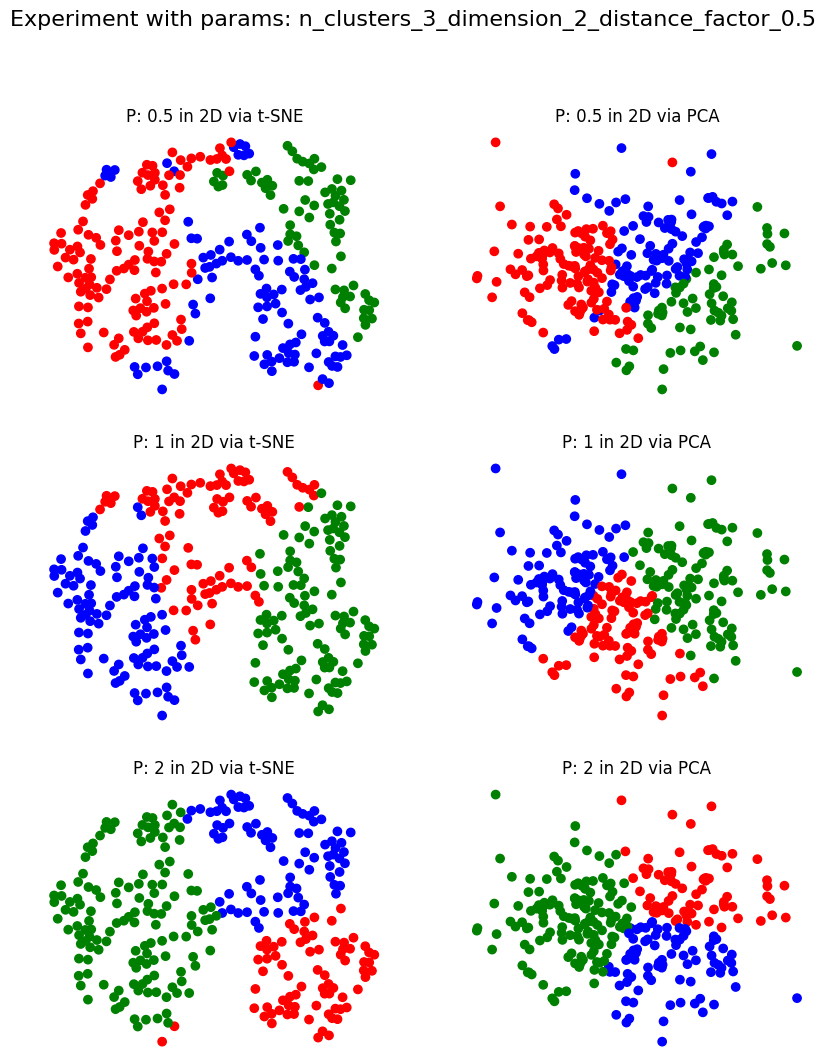

     Adjusted Rand Index  Mutual Information Score
0.5             0.222254                  0.261744
1.0             0.262111                  0.308673
2.0             0.257547                  0.288555
Processed with p 0.5
Processed with p 1
Processed with p 2


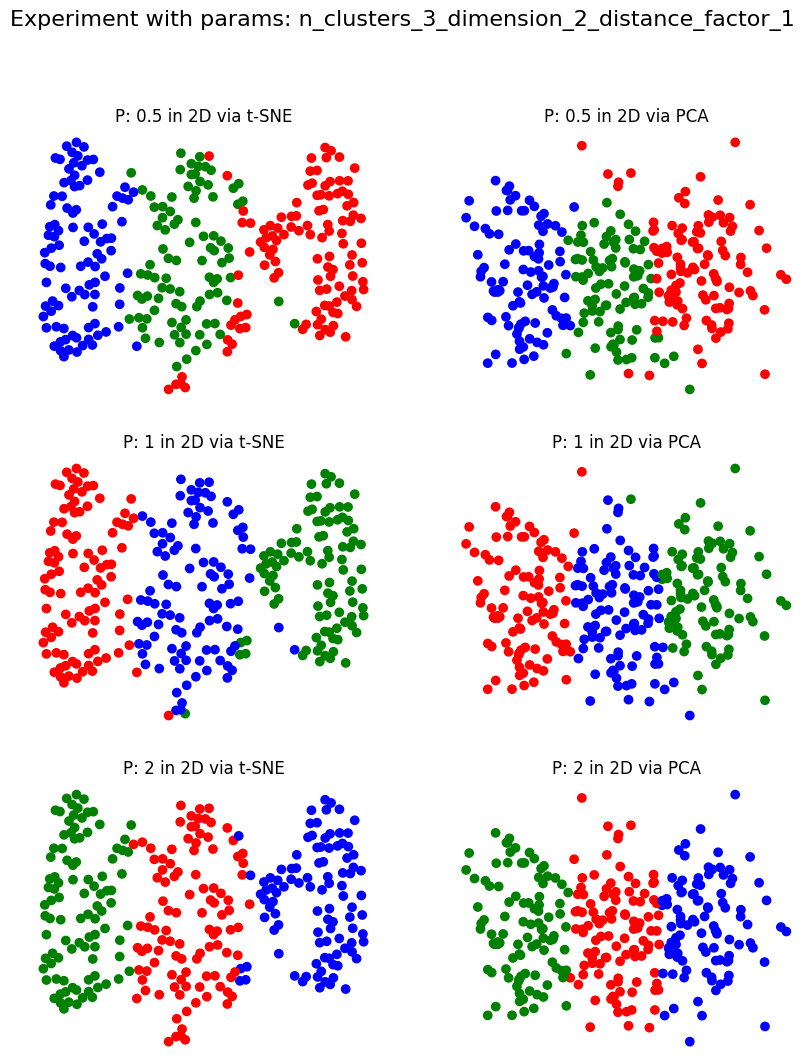

     Adjusted Rand Index  Mutual Information Score
0.5             0.646479                  0.676862
1.0             0.700251                  0.722152
2.0             0.749463                  0.771754


KeyboardInterrupt: 

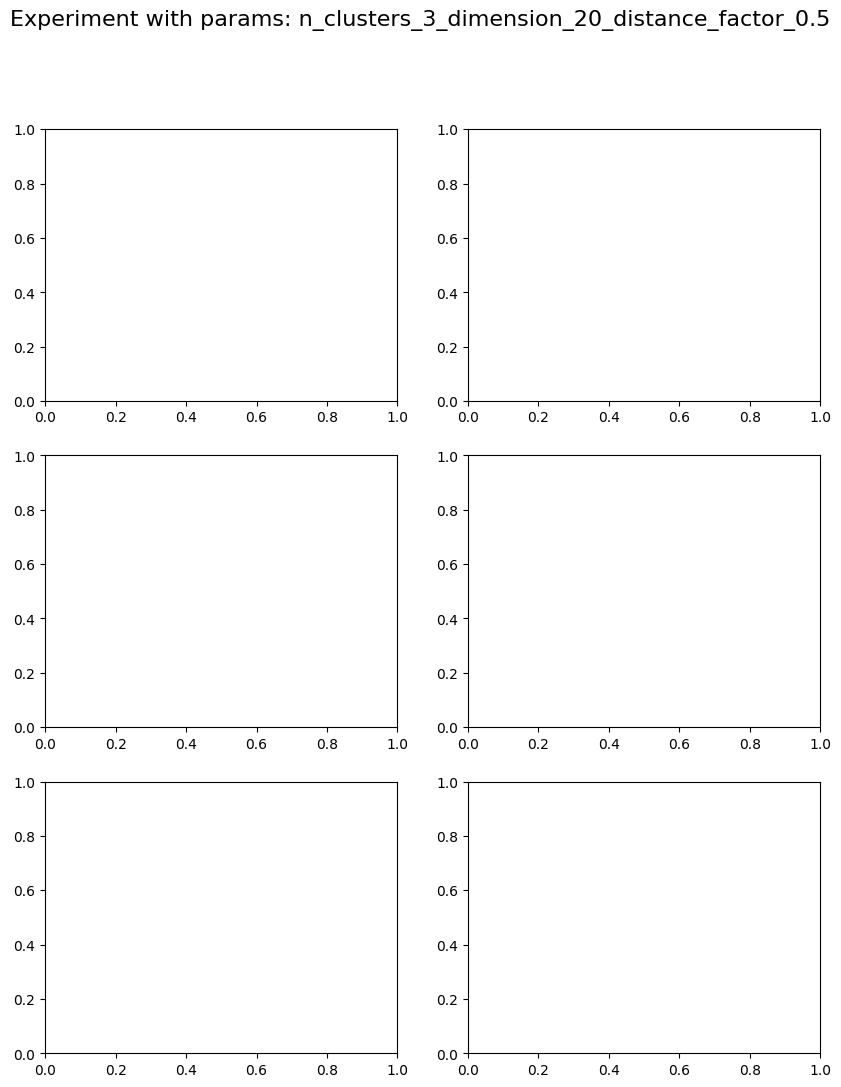

In [23]:
for dimension in params['dimension']:
    means = [np.zeros(dimension), np.ones(dimension), -np.ones(dimension), np.ones(dimension) * -1 + 1, np.ones(dimension) + -1]
    stds = [0.5, 0.5, 0.5, 0.5, 0.5]
    n_points_per_cluster = 100

    for distance_factor in params['distance_factor']:
        data, true_labels = generate_clusters(n_clusters, means, stds, n_points_per_cluster, dimension, distance_factor)

        p_values = params['parameters']
        data_map = dict.fromkeys(p_values)
        len_p_values = len(p_values)

        fig, axs = plt.subplots(len_p_values, 2, figsize=(10, 4*len_p_values))

        experiment_name = f'n_clusters_{n_clusters}_dimension_{dimension}_distance_factor_{distance_factor}'
        fig.suptitle(f'Experiment with params: {experiment_name}', fontsize=16)

        for index, p in enumerate(p_values):

            kmeans = KMeans(n_clusters=n_clusters, p=p)
            centroids, labels = kmeans.fit(data)
            data_map[p] = labels

            make_plots(axs, index, color_map, data, labels, f'P: {p}')
            print(f'Processed with p {p}')
        plt.show()
        fig.savefig(f'images/{experiment_name}.png', dpi=600)

        print_metrics(true_labels, data_map, params)


# Test

In [35]:
import numpy as np
from scipy.optimize import minimize

def kmeans_obj(X, r, centroids):
    # Calculate the k-means objective function
    obj = 0
    for k in range(len(centroids)):
        obj += np.sum((X[r==k] - centroids[k])**2)
    return obj

def optimize_centroids(X, k):
    # Randomly initialize the cluster centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    
    # Define the function to be optimized
    def f(centroids_flat):
        centroids = centroids_flat.reshape(k, -1)
        r = np.argmin(np.sum((X[:, np.newaxis, :] - centroids)**2, axis=2), axis=1)
        obj = kmeans_obj(X, r, centroids)
        return obj
    
    # Flatten the centroids array for the optimizer
    x0 = centroids.flatten()
    
    # Define the bounds for the optimizer
    bounds = [(None, None)] * x0.shape[0]
    
    # Call the minimize function with the SLSQP optimizer
    result = minimize(f, x0, method='SLSQP', bounds=bounds)
    
    # Reshape the optimized centroids array
    centroids = result.x.reshape(k, -1)
    
    return centroids



# Generate some sample data with 3 features
dimension = 50
means = [np.zeros(dimension), np.ones(dimension), -np.ones(dimension), np.ones(dimension) * -1 + 1, np.ones(dimension) + -1]
stds = [0.5, 0.5, 0.5, 0.5, 0.5]
data, true_labels = generate_clusters(2, means, stds, 100, dimension, 1)

# Optimize the cluster centroids
centroids = optimize_centroids(data, k=3)

# Print the optimized centroids
print("Optimized centroids:\n", centroids)



Optimized centroids:
 [[ 0.02184599  0.01582636  0.08565559  0.04904732  0.05656201 -0.00431265
   0.02651121 -0.00816545  0.03847081 -0.03032619 -0.03722719 -0.07056265
   0.11582087  0.05089307 -0.01913637  0.01930585  0.07154172 -0.04709084
  -0.02320932 -0.10510062  0.01027066  0.02538071  0.04823859 -0.01768174
   0.03701743 -0.05547828 -0.03140228 -0.01105485  0.02302035 -0.03566936
  -0.0199458   0.03113983  0.03208562  0.07716761  0.05298986 -0.02186242
  -0.0088583   0.01931615  0.04858517 -0.00389963  0.02343439  0.06373581
  -0.0348564   0.02529171  0.05050382 -0.04988297 -0.04960596 -0.00496082
  -0.00913833  0.02131124]
 [ 1.00889995  0.97814247  1.02521798  0.91929843  0.97260587  0.9275196
   0.98114255  1.02869014  1.04414557  1.06762779  0.96758499  1.05609508
   0.98630355  0.95188227  0.98284177  0.95159943  0.97311083  1.00486553
   1.01194024  0.95722039  1.066799    0.95484179  1.0270497   0.9333934
   1.02408926  1.03922038  0.94004759  1.09242305  0.9501112   0.